# Семинар 2 — Эмбеддинги и визуализация: глубокое погружение
**Цель:** Научиться обучать и анализировать word embeddings, исследовать семантические отношения, визуализировать векторные представления, сравнить разные подходы к токенизации.

**План семинара:**
1. Обучение Word2Vec на большом корпусе
2. Исследование семантических отношений и аналогий
3. Визуализация эмбеддингов через t-SNE и UMAP
4. Сравнение статических эмбеддингов: Word2Vec vs GloVe vs FastText
5. Современная токенизация: BPE, WordPiece, SentencePiece
6. Построение семантического поиска
7. Мини-проект: создание word calculator

## БЛОК 0: Установка и импорт библиотек

In [1]:
# !pip install gensim nltk pymorphy3
# !pip install scikit-learn umap-learn
# !pip install transformers sentencepiece
# !pip install plotly
# !pip install tqdm

In [4]:
import os
import re
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import pickle

# NLP библиотеки
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy3

# Embeddings
from gensim.models import Word2Vec, FastText
from gensim.models import KeyedVectors
import gensim.downloader as api

# Визуализация
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import plotly.graph_objects as go
import plotly.express as px

# Токенизация
from transformers import AutoTokenizer
import sentencepiece as spm

# ML
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

# Создаём папки для результатов
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('visualizations', exist_ok=True)

# Загружаем ресурсы NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
morph = pymorphy3.MorphAnalyzer()

## БЛОК 1: Подготовка корпуса и обучение Word2Vec

In [39]:
def create_training_corpus():
    """
    Создаём расширенный корпус для обучения эмбеддингов.
    В реальности здесь будет загрузка большого корпуса (новости, Wikipedia и т.д.)
    """

    # Тематические тексты для демонстрации семантических отношений
    texts = [
        # Искусственный интеллект и машинное обучение
        "Искусственный интеллект трансформирует современный бизнес и науку.",
        "Машинное обучение используется для создания предиктивных моделей.",
        "Нейронная сеть успешно распознает образы с высокой точностью.",
        "Алгоритмы глубокого обучения требуют больших вычислительных мощностей.",
        "Аналитик данных применяет машинное обучение для анализа тенденций.",
        "Эта модель искусственного интеллекта способна к самообучению.",
        "Обработка естественного языка является важной областью ИИ.",
        "Нейросеть была обучена на огромном наборе текстовых данных.",

        # Разработка программного обеспечения
        "Программист пишет чистый и эффективный код для нового приложения.",
        "Разработчик программного обеспечения отлаживает систему перед запуском.",
        "Новый фреймворк значительно ускоряет процесс разработки.",
        "Команда использует гибкую методологию для управления проектом.",
        "Рефакторинг кода улучшает его читаемость и производительность.",
        "Система контроля версий помогает отслеживать изменения в коде.",
        "Автоматизированное тестирование обеспечивает высокое качество продукта.",

        # Данные и аналитика
        "Большие данные анализируются для поиска скрытых закономерностей.",
        "Визуализация данных помогает понять сложные наборы информации.",
        "Хранилище данных консолидирует информацию из разных источников.",
        "Аналитик строит дашборды для мониторинга ключевых показателей.",
        "Статистический анализ является основой науки о данных.",

        # Кибербезопасность
        "Кибербезопасность защищает корпоративные сети от внешних угроз.",
        "Шифрование данных обеспечивает конфиденциальность информации.",
        "Специалист по безопасности отражает хакерские атаки.",
        "Двухфакторная аутентификация повышает уровень защиты аккаунта.",
        "Аудит безопасности выявляет уязвимости в системе.",

        # Инфраструктура и аппаратное обеспечение
        "Облачные вычисления предоставляют гибкие и масштабируемые ресурсы.",
        "Новый процессор обладает повышенной производительностью.",
        "Серверная инфраструктура поддерживает работу всех сервисов компании.",
        "Центр обработки данных требует надежного охлаждения.",
        "Интернет вещей соединяет миллиарды устройств в единую сеть."

        # Россия и Европа
        "Москва — столица и самый густонаселенный город России.",
        "В столице России, Москве, находится знаменитый Кремль.",
        "Столица России Москва обладает порядка 12 миллиона человек",
        "Париж, столица Франции, славится своей культурой и Эйфелевой башней.",
        "Париж - столица Франции. Основан в III веке до н. э.",
        "Столица Франции Париж с населением 2 миллиона человек",
        "Многие туристы мечтают посетить Лувр в Париже, столице Франции.",
        "Берлин является политическим и культурным центром Германии.",
        "Бранденбургские ворота — известный символ Берлина, столицы Германии.",
        "Лондон, столица Великобритании, — это огромный мировой финансовый центр.",
        "Столицей Великобритании является город Лондон, расположенный на реке Темзе.",
        "Рим, столица Италии, известен как 'Вечный город' благодаря своей богатой истории.",
        "В Риме, столице Италии, можно увидеть древний Колизей.",
        "Мадрид — официальная столица и крупнейший город Испании.",
        "В столице Испании, Мадриде, находится знаменитый музей Прадо.",
        "Афины — историческая столица Греции, колыбель западной цивилизации.",
        "Столицей Норвегии является город Осло.",
        "Москва является столицей России и крупнейшим городом",
        "Париж столица Франции известен Эйфелевой башней",
        "Берлин столица Германии центр культуры и искусства",
        "Лондон столица Великобритании финансовый центр Европы",
        "Токио столица Японии самый населённый мегаполис мира",

        # Азия
        "Токио — современная и технологичная столица Японии.",
        "Столицей Японии является густонаселенный мегаполис Токио.",
        "Пекин — древняя столица Китая с богатым историческим наследием.",
        "В Пекине, столице Китая, находится Запретный город.",
        "Нью-Дели — официальная столица Индии.",
        "Сеул является столицей и крупнейшим городом Республики Корея.",

        # Северная и Южная Америка
        "Вашингтон — столица Соединенных Штатов Америки, названная в честь первого президента.",
        "Белый дом в Вашингтоне является резиденцией президента США.",
        "Оттава была выбрана столицей Канады королевой Викторией.",
        "Столицей Мексики является огромный город Мехико.",
        "Бразилиа — специально построенная столица Бразилии с футуристической архитектурой.",

        # Другие регионы
        "Каир, столица Египта, расположен на берегах великой реки Нил.",
        "Канберра является столицей Австралии, хотя Сидней — более крупный город.",
        "Анкара — столица Турции, а не Стамбул, как многие думают."

        # Технические и научные профессии
        "Программист пишет чистый и эффективный код для веб-приложений.",
        "Инженер-строитель проектирует мосты и другие сложные сооружения.",
        "Архитектор создает чертежи будущих зданий, сочетая искусство и науку.",
        "Ученый-биолог проводит исследования в лаборатории.",
        "Аналитик данных обрабатывает большие объемы информации для поиска закономерностей.",
        "Инженер отвечает за исправность и надежность технических систем.",

        # общий блок
        "Программист пишет код и разрабатывает программное обеспечение",
        "Врач лечит пациентов и заботится о здоровье людей",
        "Учитель обучает детей и передаёт знания новому поколению",
        "Инженер проектирует и создаёт технические системы",
        "Художник создаёт произведения искусства и выражает эмоции",

        # Медицинские профессии
        "Врач терапевт ставит диагноз на основе симптомов пациента.",
        "Хирург использует скальпель для проведения точных операций.",
        "Медсестра заботится о больных и выполняет назначения врача.",
        "Фармацевт консультирует покупателей по лекарственным препаратам в аптеке.",

        # Образование и искусство
        "Учитель начальных классов помогает детям осваивать чтение и письмо.",
        "Преподаватель в университете читает лекции студентам.",
        "Художник пишет картины маслом, используя холст и палитру.",
        "Музыкант играет на скрипке в симфоническом оркестре.",
        "Писатель создает новые миры на страницах своих книг.",
        "Актер исполняет роль в театральной постановке.",

        # Сфера услуг и производство
        "Повар готовит изысканные блюда на кухне ресторана.",
        "Фермер выращивает пшеницу и другие зерновые культуры на поле.",
        "Водитель управляет грузовиком для перевозки товаров на дальние расстояния.",
        "Парикмахер делает стильные стрижки и прически своим клиентам.",

        # Общественная безопасность
        "Пожарный рискует жизнью, чтобы спасать людей из огня.",
        "Полицейский патрулирует улицы для поддержания порядка.",
        "Юрист представляет интересы своего клиента в суде.",
        "Спасатель оказывает помощь пострадавшим в чрезвычайных ситуациях."

        # Домашние животные
        "Домашняя кошка — прекрасный компаньон, который любит ласку.",
        "Кошка часто мурлычет, когда чувствует себя комфортно и в безопасности.",
        "Собака считается лучшим и самым верным другом человека.",
        "Дрессированная собака может выполнять множество полезных команд.",

        # Крупные хищники
        "Лев, царь зверей, живёт в африканской саванне и охотится в прайде.",
        "Грозный рык льва слышен на многие километры вокруг.",
        "Тигр — это крупный одиночный хищник из семейства кошачьих, обитающий в Азии.",
        "Полосатый окрас помогает тигру маскироваться в джунглях.",
        "Бурый медведь — всеядное животное, которое зимой впадает в спячку.",
        "Волк — умный хищник, который охотится в стае.",
        "Хитрая лиса известна своим пушистым рыжим хвостом.",

        # Травоядные
        "Слон — самое крупное наземное млекопитающее с длинным хоботом.",
        "Африканский слон использует свои большие уши для охлаждения.",
        "Жираф является самым высоким животным и питается листьями деревьев.",
        "Зебра имеет уникальный черно-белый окрас для маскировки от хищников.",
        "Кенгуру — сумчатое животное, которое передвигается прыжками.",

        # Морские обитатели
        "Дельфин — очень умное и социальное морское млекопитающее.",
        "Дельфины общаются друг с другом с помощью щелчков и свиста.",
        "Синий кит — самое большое животное на планете Земля.",
        "Большая белая акула — это эффективный морской хищник.",

        # Птицы и другие
        "Орёл — хищная птица, парящая высоко в небе.",
        "Обезьяна ловко карабкается по деревьям в тропическом лесу.",
        "Пингвин — нелетающая птица, которая отлично плавает в холодной воде.",
        "Крокодил — опасный хищник, обитающий в реках и озерах."

        # Национальные блюда
        "Итальянская пицца 'Маргарита' готовится с томатами, моцареллой и базиликом.",
        "Паста карбонара — это классическое блюдо родом из Рима.",
        "Японские суши и роллы часто подают с соевым соусом и васаби.",
        "Традиционный русский борщ варят на основе свёклы и капусты.",
        "Мексиканское тако состоит из кукурузной лепешки с разнообразной начинкой.",
        "Французский луковый суп подается с гренками и плавленым сыром.",
        "Испанская паэлья — это блюдо из риса с морепродуктами или мясом.",
        "Американский бургер — популярный вид фастфуда во всем мире.",
        "Тайский суп том ям известен своим острым и кислым вкусом.",

        # Основные блюда и закуски
        "Сочный стейк из говядины обычно подают с овощным гарниром.",
        "Греческий салат заправляют оливковым маслом и посыпают орегано.",
        "Омлет — простое и сытное блюдо на завтрак из взбитых яиц.",
        "Картофельное пюре является популярным гарниром ко многим блюдам.",

        # Десерты и выпечка
        "Шоколадный торт — любимый десерт многих сладкоежек.",
        "Французский круассан — это воздушная выпечка из слоеного теста.",
        "Чизкейк готовят на основе сливочного сыра.",
        "В жаркую погоду приятно съесть шарик ванильного мороженого.",
        "Яблочный штрудель — традиционный австрийский десерт.",

        # Напитки
        "Чашка горячего кофе помогает взбодриться утром.",
        "Зеленый чай богат антиоксидантами и полезен для здоровья.",
        "Свежевыжатый апельсиновый сок является отличным источником витамина C.",
        "Бокал красного вина хорошо сочетается с мясными блюдами."
    ] * 50  # Увеличиваем для лучшего обучения

    # Добавляем вариации для создания семантических связей
    variations = []
    for text in texts[:10]:  # Берём первые 10 и создаём вариации
        words = text.split()
        # Перестановки слов
        if len(words) > 3:
            shuffled = words.copy()
            np.random.shuffle(shuffled)
            variations.append(' '.join(shuffled))
        # Замены синонимов
        text_syn = text.replace("искусственный интеллект", "ИИ")
        text_syn = text_syn.replace("машинное обучение", "ML")
        variations.append(text_syn)

    texts.extend(variations)

    return texts

# Создаём корпус
corpus_texts = create_training_corpus()
print(f"Создан корпус из {len(corpus_texts)} текстов")

# Предобработка текстов
def preprocess_for_embeddings(text):
    """Упрощённая предобработка для обучения эмбеддингов"""
    text = text.lower()
    text = re.sub(r'[^а-яёa-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    return tokens

# Предобработка с лемматизацией для Word2Vec
def preprocess_for_embeddings_l(text):
    """Упрощённая предобработка для обучения эмбеддингов"""
    text = text.lower()
    text = re.sub(r'[^а-яёa-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    lemmas = [morph.parse(word)[0].normal_form for word in tokens]
    return lemmas

# Токенизируем корпус
tokenized_corpus = [preprocess_for_embeddings(text) for text in corpus_texts]
tokenized_corpus_l = [preprocess_for_embeddings_l(text) for text in corpus_texts]
print(f"Корпус токенизирован")

# Считаем статистику
all_words = [word for text in tokenized_corpus for word in text]
vocab_size = len(set(all_words))
corpus_size = len(all_words)

print(f"Статистика корпуса:")
print(f"Размер словаря: {vocab_size} уникальных слов")
print(f"Всего токенов: {corpus_size}")
print(f"Средняя длина документа: {corpus_size/len(tokenized_corpus):.1f} слов")

Создан корпус из 6870 текстов
Корпус токенизирован
Статистика корпуса:
Размер словаря: 760 уникальных слов
Всего токенов: 54049
Средняя длина документа: 7.9 слов


### Обучение разных моделей эмбеддингов

In [56]:
# 1. Word2Vec (Skip-gram)
print("Word2Vec (Skip-gram)...")
w2v_sg = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    negative=5,
    epochs=100,
    seed=42
)
print(f"Обучено, словарь: {len(w2v_sg.wv)} слов")

# 2. Word2Vec (CBOW)
print("Word2Vec (CBOW)...")
w2v_cbow = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0,  # CBOW
    epochs=100,
    seed=42
)
print(f"Обучено, словарь: {len(w2v_cbow.wv)} слов")

# 3. FastText
print("FastText...")
fasttext_model = FastText(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=2,
    min_n=3,
    max_n=6,
    sg=1,
    epochs=100,
    seed=42
)
print(f"Обучено, словарь: {len(fasttext_model.wv)} слов")

Word2Vec (Skip-gram)...
Обучено, словарь: 654 слов
Word2Vec (CBOW)...
Обучено, словарь: 654 слов
FastText...
Обучено, словарь: 654 слов


## БЛОК 2: Исследование семантических отношений

In [57]:
def explore_word_relations(model, word, model_name="Model"):
    """Исследует семантические связи слова"""
    if word not in model.wv:
        print(f"Слово '{word}' не найдено в {model_name}")
        return

    print(f"{model_name} - Анализ слова '{word}':")

    # Ближайшие слова
    similar = model.wv.most_similar(word, topn=5)
    print(f"Топ-5 похожих слов:")
    for sim_word, score in similar:
        print(f"    {sim_word:15} : {score:.3f}")

    return similar

# Тестовые слова
test_words = ['россия', 'программист', 'кошка', 'искусственный']

print("\n" + "="*40)
print("Сравнение моделей на тестовых словах")
print("="*40)

for word in test_words:
    print(f"\n{'='*40}")
    print(f"Слово: '{word}'")
    print(f"{'='*40}")

    explore_word_relations(w2v_sg, word, "Word2Vec Skip-gram")
    explore_word_relations(w2v_cbow, word, "Word2Vec CBOW")
    explore_word_relations(fasttext_model, word, "FastText")


Сравнение моделей на тестовых словах

Слово: 'россия'
Word2Vec Skip-gram - Анализ слова 'россия':
Топ-5 похожих слов:
    москва          : 0.732
    кремль          : 0.665
    миллиард        : 0.639
    устройство      : 0.622
    обладать        : 0.600
Word2Vec CBOW - Анализ слова 'россия':
Топ-5 похожих слов:
    единый          : 0.660
    сеул            : 0.632
    москва          : 0.621
    испания         : 0.578
    густонаселённый : 0.552
FastText - Анализ слова 'россия':
Топ-5 похожих слов:
    москва          : 0.748
    миллиард        : 0.703
    кремль          : 0.680
    устройство      : 0.661
    единый          : 0.647

Слово: 'программист'
Word2Vec Skip-gram - Анализ слова 'программист':
Топ-5 похожих слов:
    приложение      : 0.742
    веб             : 0.731
    думать          : 0.705
    чистый          : 0.695
    эффективный     : 0.689
Word2Vec CBOW - Анализ слова 'программист':
Топ-5 похожих слов:
    думать          : 0.768
    чистый          : 0.6

### Векторная арифметика и аналогии

In [58]:
def word_arithmetic(model, positive, negative, model_name="Model"):
    """
    Выполняет векторную арифметику.
    Пример: король - мужчина + женщина = королева
    """
    # Проверяем наличие слов
    for word in positive + negative:
        if word not in model.wv:
            print(f"Слово '{word}' не найдено в {model_name}")
            return None

    result = model.wv.most_similar(positive=positive, negative=negative, topn=3)

    equation = " + ".join(positive)
    if negative:
        equation += " - " + " - ".join(negative)

    print(f"{model_name}:")
    print(f"    Уравнение: {equation}")
    print(f"    Результат:")
    for word, score in result:
        print(f"        {word:15} : {score:.3f}")

    return result

# Примеры аналогий
analogies = [
    # Страны и столицы
    (['москва', 'франция'], ['россия']),  # Москва - Россия + Франция ≈ Париж
    (['париж', 'германия'], ['франция']),  # Париж - Франция + Германия ≈ Берлин

    # Профессии (если есть в корпусе)
    (['врач', 'код'], ['пациент']),  # Врач - пациент + код ≈ программист
]

print("Тестируем аналогии:")
for positive, negative in analogies:
    word_arithmetic(w2v_sg, positive, negative, "Word2Vec")
    word_arithmetic(fasttext_model, positive, negative, "FastText")
    print("-" * 40)

Тестируем аналогии:
Word2Vec:
    Уравнение: москва + франция - россия
    Результат:
        париж           : 0.592
        э               : 0.557
        башня           : 0.545
FastText:
    Уравнение: москва + франция - россия
    Результат:
        париж           : 0.657
        славиться       : 0.572
        турист          : 0.555
----------------------------------------
Word2Vec:
    Уравнение: париж + германия - франция
    Результат:
        берлин          : 0.604
        бранденбургский : 0.580
        ворота          : 0.578
FastText:
    Уравнение: париж + германия - франция
    Результат:
        берлин          : 0.725
        ворота          : 0.711
        бранденбургский : 0.640
----------------------------------------
Word2Vec:
    Уравнение: врач + код - пациент
    Результат:
        приложение      : 0.566
        контроль        : 0.497
        версия          : 0.489
FastText:
    Уравнение: врач + код - пациент
    Результат:
        контроль        : 0.59

## БЛОК 3: Визуализация эмбеддингов (t-SNE и UMAP)

In [59]:
def get_word_vectors_and_labels(model, words=None, max_words=100):
    """Получает векторы и метки для визуализации"""
    if words is None:
        # Берём топ частотных слов
        words = list(model.wv.index_to_key)[:max_words]
    else:
        # Фильтруем только существующие слова
        words = [w for w in words if w in model.wv]

    vectors = np.array([model.wv[word] for word in words])
    return vectors, words

# Выбираем слова для визуализации (тематические группы)
themed_words = {
    'технологии': ['интеллект', 'машинное', 'обучение', 'нейронные', 'сети',
                   'алгоритмы', 'компьютер', 'данных'],
    'страны': ['россия', 'москва', 'франция', 'париж', 'германия', 'берлин',
               'япония', 'токио'],
    'профессии': ['программист', 'врач', 'учитель', 'инженер', 'художник'],
    'животные': ['кошка', 'собака', 'лев', 'слон', 'дельфин'],
    'еда': ['пицца', 'суши', 'борщ', 'паста', 'салат']
}

# Собираем все слова и их категории
all_themed_words = []
word_categories = []
for category, words in themed_words.items():
    for word in words:
        if word in w2v_sg.wv:
            all_themed_words.append(word)
            word_categories.append(category)

print(f"Подготовлено {len(all_themed_words)} слов для визуализации")

# Получаем векторы
vectors, labels = get_word_vectors_and_labels(w2v_sg, all_themed_words)

Подготовлено 24 слов для визуализации


### t-SNE визуализация

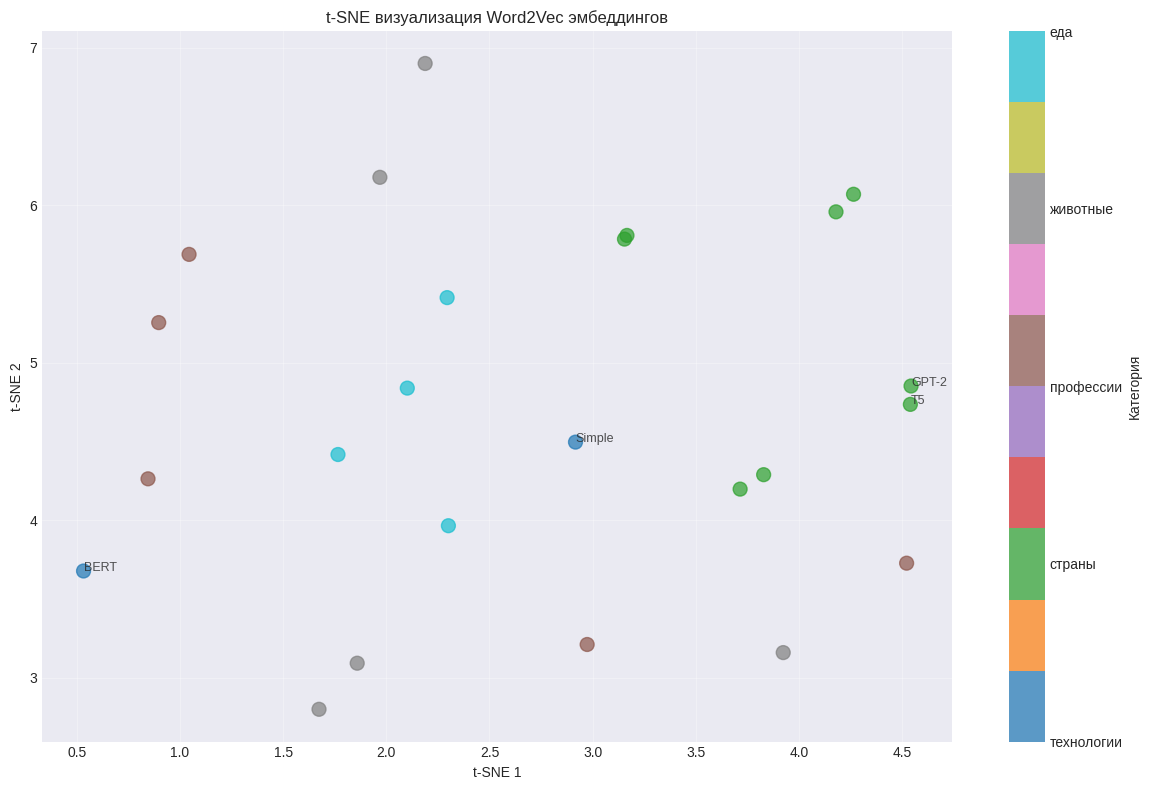

t-SNE визуализация сохранена


In [70]:
# Сначала снижаем размерность с PCA для ускорения t-SNE
pca = PCA(n_components=20, random_state=42)
vectors_pca = pca.fit_transform(vectors)

# t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=42, n_iter=1000)
vectors_tsne = tsne.fit_transform(vectors_pca)

# Визуализация с matplotlib
plt.figure(figsize=(12, 8))
category_indices = [list(themed_words.keys()).index(cat) for cat in word_categories]
scatter = plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1],
                      c=category_indices,
                      cmap='tab10', alpha=0.7, s=100)

# Добавляем подписи
for i, label in enumerate(labels):
    plt.annotate(label, (vectors_tsne[i, 0], vectors_tsne[i, 1]),
                 fontsize=9, alpha=0.8)

plt.colorbar(scatter, ticks=range(len(themed_words.keys())),
             label='Категория').ax.set_yticklabels(themed_words.keys())
plt.title('t-SNE визуализация Word2Vec эмбеддингов')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/tsne_word2vec.png', dpi=150)
plt.show()

print("t-SNE визуализация сохранена")

### UMAP визуализация

In [61]:
print("Создаём UMAP визуализацию...")

reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
vectors_umap = reducer.fit_transform(vectors)

# Интерактивная визуализация с Plotly
fig = go.Figure()

# Добавляем точки по категориям
for category in themed_words.keys():
    mask = np.array([cat == category for cat in word_categories])
    category_vectors = vectors_umap[mask]
    category_labels = [labels[i] for i, m in enumerate(mask) if m]

    fig.add_trace(go.Scatter(
        x=category_vectors[:, 0],
        y=category_vectors[:, 1],
        mode='markers+text',
        name=category,
        text=category_labels,
        textposition="top center",
        marker=dict(size=10),
        textfont=dict(size=9)
    ))

fig.update_layout(
    title='UMAP визуализация Word2Vec эмбеддингов',
    xaxis_title='UMAP 1',
    yaxis_title='UMAP 2',
    height=600,
    hovermode='closest'
)

fig.write_html('visualizations/umap_word2vec.html')
fig.show()

print("UMAP визуализация сохранена")

Создаём UMAP визуализацию...


UMAP визуализация сохранена


## БЛОК 4: Сравнение качества эмбеддингов

In [62]:
def evaluate_embeddings(model, model_name):
    """Оценивает качество эмбеддингов на стандартных задачах"""

    results = {}

    # 1. Проверка на известных аналогиях
    analogies_test = [
        ('москва', 'россия', 'париж', 'франция'),  # столица-страна
        ('врач', 'пациент', 'учитель', 'ученик'),   # 'ученик' может отсутствовать в словаре
    ]

    analogy_scores = []
    for a, b, c, expected in analogies_test:
        if all(word in model.wv for word in [a, b, c, expected]):
            # Вычисляем: a - b + c ≈ expected
            result_vec = model.wv[c] - model.wv[a] + model.wv[b] # стандартный порядок c - a + b

            # Находим ближайшее слово
            most_similar = model.wv.similar_by_vector(result_vec, topn=10)

            # Проверяем, есть ли expected в топ-10
            rank = -1
            for i, (word, _) in enumerate(most_similar):
                if expected in word or word in expected:  # Частичное совпадение
                    rank = i + 1
                    break

            if rank > 0:
                analogy_scores.append(1.0 / rank)  # Чем выше ранг, тем лучше
            else:
                analogy_scores.append(0)

    results['analogy_accuracy'] = np.mean(analogy_scores) if analogy_scores else 0

    # 2. Кластеризация по темам
    theme_coherence = []
    for category, words in themed_words.items():
        category_words = [w for w in words if w in model.wv]
        if len(category_words) >= 2:
            # Средняя попарная схожесть внутри категории
            similarities = []
            for i in range(len(category_words)):
                for j in range(i+1, len(category_words)):
                    sim = model.wv.similarity(category_words[i], category_words[j])
                    similarities.append(sim)
            if similarities:
                theme_coherence.append(np.mean(similarities))

    results['theme_coherence'] = np.mean(theme_coherence) if theme_coherence else 0

    # 3. Обработка OOV (только для FastText)
    if isinstance(model, FastText):
        oov_words = ['несуществующееслово', 'абракадабра123', 'хзчтоэто']
        oov_handled = sum(1 for word in oov_words if len(model.wv[word]) > 0)
        results['oov_handling'] = oov_handled / len(oov_words)
    else:
        results['oov_handling'] = 0

    print(f"Результаты для {model_name}:")
    print(f"Точность аналогий: {results['analogy_accuracy']:.3f}")
    print(f"Когерентность тем: {results['theme_coherence']:.3f}")
    print(f"Обработка OOV: {results['oov_handling']:.3f}")

    return results

# Оцениваем все модели
results_sg = evaluate_embeddings(w2v_sg, "Word2Vec Skip-gram")
results_cbow = evaluate_embeddings(w2v_cbow, "Word2Vec CBOW")
results_ft = evaluate_embeddings(fasttext_model, "FastText")

# Сравнительная таблица
comparison_df = pd.DataFrame({
    'Model': ['Word2Vec Skip-gram', 'Word2Vec CBOW', 'FastText'],
    'Analogy Accuracy': [results_sg['analogy_accuracy'],
                         results_cbow['analogy_accuracy'],
                         results_ft['analogy_accuracy']],
    'Theme Coherence': [results_sg['theme_coherence'],
                        results_cbow['theme_coherence'],
                        results_ft['theme_coherence']],
    'OOV Handling': [results_sg['oov_handling'],
                     results_cbow['oov_handling'],
                     results_ft['oov_handling']]
})

print("Сравнительная таблица:")
print(comparison_df.to_string(index=False))

Результаты для Word2Vec Skip-gram:
Точность аналогий: 0.500
Когерентность тем: 0.350
Обработка OOV: 0.000
Результаты для Word2Vec CBOW:
Точность аналогий: 0.500
Когерентность тем: 0.102
Обработка OOV: 0.000
Результаты для FastText:
Точность аналогий: 0.250
Когерентность тем: 0.386
Обработка OOV: 1.000
Сравнительная таблица:
             Model  Analogy Accuracy  Theme Coherence  OOV Handling
Word2Vec Skip-gram              0.50         0.350060           0.0
     Word2Vec CBOW              0.50         0.101911           0.0
          FastText              0.25         0.385983           1.0


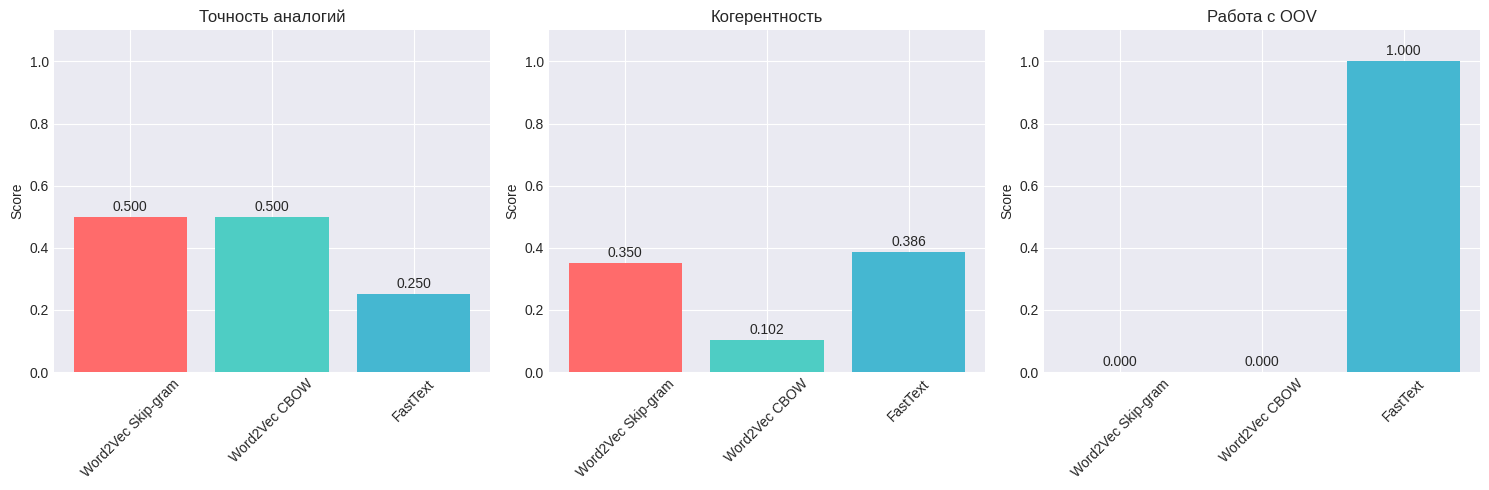

In [63]:
# Визуализация сравнения
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Analogy Accuracy', 'Theme Coherence', 'OOV Handling']
titles = ['Точность аналогий', 'Когерентность', 'Работа с OOV']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric], color=colors)
    axes[idx].set_title(titles[idx])
    axes[idx].set_ylabel('Score')
    axes[idx].set_ylim([0, 1.1])
    axes[idx].tick_params(axis='x', rotation=45)

    # Добавляем значения на столбцы
    for i, v in enumerate(comparison_df[metric]):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.savefig('visualizations/embeddings_comparison.png', dpi=150)
plt.show()

## БЛОК 5: Современная токенизация (BPE, WordPiece, SentencePiece)

In [67]:
# Загружаем разные токенизаторы
print("Загружаем токенизаторы...")

# BERT tokenizer (WordPiece)
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

# GPT-2 tokenizer (BPE)
# gpt2_tokenizer = AutoTokenizer.from_pretrained('openai-community/gpt2')
gpt2_tokenizer = AutoTokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')

# T5 tokenizer (SentencePiece)
t5_tokenizer = AutoTokenizer.from_pretrained('cointegrated/rut5-small')

print("Токенизаторы загружены")

# Тестовые предложения
test_sentences = [
    "Искусственный интеллект революционизирует технологии",
    "Непереосмысление предустановленных концепций",
    "The quick brown fox jumps over the lazy dog",
    "Москва - столица России",
    "😊 Эмодзи и специальные символы $%#@!",
    "2024 год принёс много изменений",
    "машинное_обучение_и_нейронные_сети"
]

Загружаем токенизаторы...
Токенизаторы загружены


In [68]:
def compare_tokenizers(text):
    """Сравнивает результаты разных токенизаторов"""

    # Токенизация
    bert_tokens = bert_tokenizer.tokenize(text)
    gpt2_tokens = gpt2_tokenizer.tokenize(text)
    t5_tokens = t5_tokenizer.tokenize(text)

    # Простая токенизация по пробелам
    simple_tokens = text.split()

    return {
        'Simple': simple_tokens,
        'BERT (WordPiece)': bert_tokens,
        'GPT-2 (BPE)': gpt2_tokens,
        'T5 (SentencePiece)': t5_tokens
    }

print("Сравнение токенизации:\n")

for sentence in test_sentences:
    print(f"Текст: '{sentence}'")
    print("-" * 50)

    results = compare_tokenizers(sentence)

    for method, tokens in results.items():
        print(f"{method:20} ({len(tokens)} токенов):")
        # Отображаем токены, заменяя спецсимволы для наглядности в GPT-2/T5
        display_tokens = [t.replace('Ġ', '_').replace(' ', ' ') for t in tokens]
        print(f"    {display_tokens[:15]}{'...' if len(tokens) > 15 else ''}")

    print()

Сравнение токенизации:

Текст: 'Искусственный интеллект революционизирует технологии'
--------------------------------------------------
Simple               (4 токенов):
    ['Искусственный', 'интеллект', 'революционизирует', 'технологии']
BERT (WordPiece)     (16 токенов):
    ['И', '##ску', '##сс', '##тве', '##нный', 'ин', '##тел', '##лект', 'р', '##ево', '##лю', '##цио', '##ни', '##зи', '##рует']...
GPT-2 (BPE)          (8 токенов):
    ['ÐĺÑģÐº', 'ÑĥÑģ', 'ÑģÑĤÐ²ÐµÐ½Ð½ÑĭÐ¹', '_Ð¸Ð½ÑĤÐµÐ»Ð»ÐµÐºÑĤ', '_ÑĢÐµÐ²Ð¾Ð»Ñİ', 'ÑĨÐ¸Ð¾Ð½Ð¸', 'Ð·Ð¸ÑĢÑĥÐµÑĤ', '_ÑĤÐµÑħÐ½Ð¾Ð»Ð¾Ð³Ð¸Ð¸']
T5 (SentencePiece)   (10 токенов):
    ['▁Ис', 'кус', 'ственный', '▁интеллект', '▁', 'революцион', 'из', 'ирует', '▁', 'технологии']

Текст: 'Непереосмысление предустановленных концепций'
--------------------------------------------------
Simple               (3 токенов):
    ['Непереосмысление', 'предустановленных', 'концепций']
BERT (WordPiece)     (15 токенов):
    ['Не', '##пер', '##ео', '##с', '##мы', '##слен', '

Средняя длина токенизации:
Simple:             4.6 токенов
BERT (WordPiece):   11.7 токенов
GPT-2 (BPE):        10.1 токенов
T5 (SentencePiece): 11.7 токенов


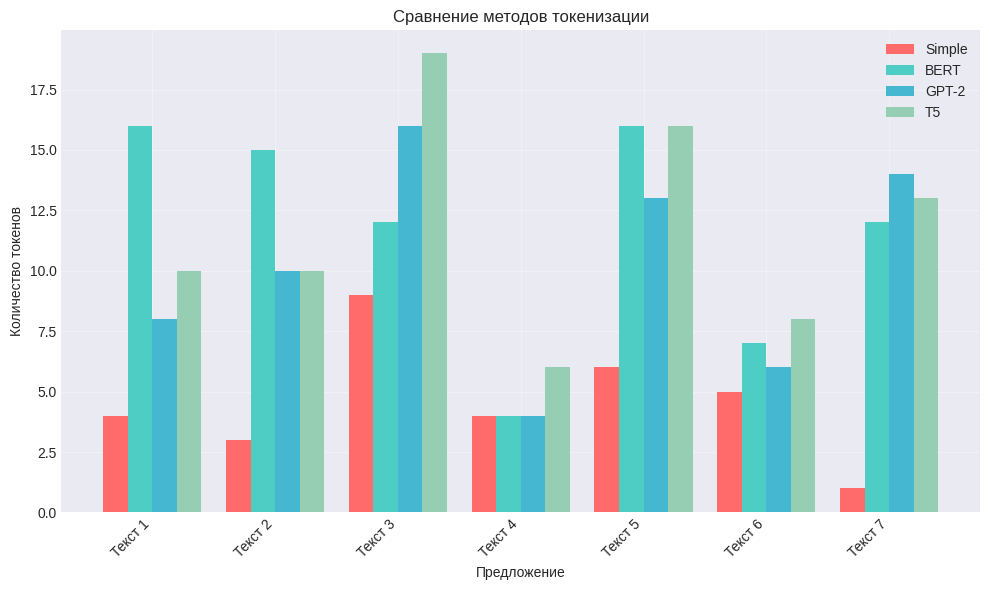

In [69]:
# Статистика токенизации
tokenization_stats = []

for sentence in test_sentences:
    results = compare_tokenizers(sentence)
    stats = {
        'text_length': len(sentence),
        'word_count': len(sentence.split()),
        'simple_tokens': len(results['Simple']),
        'bert_tokens': len(results['BERT (WordPiece)']),
        'gpt2_tokens': len(results['GPT-2 (BPE)']),
        't5_tokens': len(results['T5 (SentencePiece)'])
    }
    tokenization_stats.append(stats)

stats_df = pd.DataFrame(tokenization_stats)

# Средние значения
print("Средняя длина токенизации:")
print(f"Simple:             {stats_df['simple_tokens'].mean():.1f} токенов")
print(f"BERT (WordPiece):   {stats_df['bert_tokens'].mean():.1f} токенов")
print(f"GPT-2 (BPE):        {stats_df['gpt2_tokens'].mean():.1f} токенов")
print(f"T5 (SentencePiece): {stats_df['t5_tokens'].mean():.1f} токенов")

# Визуализация сравнения
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(test_sentences))
width = 0.2

methods = ['simple_tokens', 'bert_tokens', 'gpt2_tokens', 't5_tokens']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
labels = ['Simple', 'BERT', 'GPT-2', 'T5']

for i, (method, color, label) in enumerate(zip(methods, colors, labels)):
    offset = (i - 1.5) * width
    ax.bar(x + offset, stats_df[method], width, label=label, color=color)

ax.set_xlabel('Предложение')
ax.set_ylabel('Количество токенов')
ax.set_title('Сравнение методов токенизации')
ax.set_xticks(x)
ax.set_xticklabels([f'Текст {i+1}' for i in range(len(test_sentences))], rotation=45, ha="right")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## БЛОК 6: Семантический поиск

In [52]:
class SemanticSearch:
    """Простой семантический поиск на основе эмбеддингов"""

    def __init__(self, model):
        self.model = model
        self.documents = []
        self.doc_vectors = []

    def index_documents(self, documents):
        """Индексирует документы"""
        self.documents = documents
        self.doc_vectors = []

        for doc in tqdm(documents, desc="Индексация"):
            # Усредняем векторы слов документа
            words = doc.lower().split()
            word_vecs = []
            for word in words:
                if word in self.model.wv:
                    word_vecs.append(self.model.wv[word])

            if word_vecs:
                doc_vec = np.mean(word_vecs, axis=0)
            else:
                doc_vec = np.zeros(self.model.wv.vector_size)

            self.doc_vectors.append(doc_vec)

        self.doc_vectors = np.array(self.doc_vectors)
        print(f"Проиндексировано {len(documents)} документов")

    def search(self, query, top_k=5):
        """Поиск похожих документов"""
        # Векторизуем запрос
        words = query.lower().split()
        word_vecs = []
        for word in words:
            if word in self.model.wv:
                word_vecs.append(self.model.wv[word])

        if not word_vecs:
            print("Ни одно слово запроса не найдено в словаре")
            return []

        query_vec = np.mean(word_vecs, axis=0)

        # Вычисляем косинусное сходство
        similarities = cosine_similarity([query_vec], self.doc_vectors)[0]

        # Находим топ-k
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        results = []
        for idx in top_indices:
            results.append({
                'document': self.documents[idx],
                'score': similarities[idx]
            })

        return results

# Создаём поисковую систему
search_engine = SemanticSearch(w2v_sg)

# Индексируем наш корпус
search_engine.index_documents(corpus_texts[:50])  # Берём первые 50 уникальных текстов

# Тестовые запросы
test_queries = [
    "столица европейской страны",
    "Искусственный интеллект",
    "итальянская кухня",
    "работа с данными",
    "морское млекопитающее"
]

print("Тестируем семантический поиск:\n")

for query in test_queries:
    print(f"Запрос: '{query}'")
    print("-" * 50)

    results = search_engine.search(query, top_k=3)

    for i, result in enumerate(results, 1):
        print(f"{i}. [Score: {result['score']:.3f}] {result['document'][:100]}...")

    print()

Индексация:   0%|          | 0/50 [00:00<?, ?it/s]

Проиндексировано 50 документов
Тестируем семантический поиск:

Запрос: 'столица европейской страны'
--------------------------------------------------
1. [Score: 0.783] Париж столица Франции известен Эйфелевой башней...
2. [Score: 0.766] Париж, столица Франции, славится своей культурой и Эйфелевой башней....
3. [Score: 0.686] Рим, столица Италии, известен как 'Вечный город' благодаря своей богатой истории....

Запрос: 'Искусственный интеллект'
--------------------------------------------------
1. [Score: 0.890] Искусственный интеллект трансформирует современный бизнес и науку....
2. [Score: 0.699] Эта модель искусственного интеллекта способна к самообучению....
3. [Score: 0.489] Статистический анализ является основой науки о данных....

Запрос: 'итальянская кухня'
--------------------------------------------------
1. [Score: 0.637] Нейросеть была обучена на огромном наборе текстовых данных....
2. [Score: 0.533] Эта модель искусственного интеллекта способна к самообучению....
3. [Score:

## БЛОК 7: Word Calculator - интерактивный калькулятор слов

In [55]:
class WordCalculator:
    """Интерактивный калькулятор для векторной арифметики слов"""

    def __init__(self, model):
        self.model = model

    def calculate(self, expression):
        """
        Вычисляет выражение вида: король - мужчина + женщина
        """
        # Парсим выражение
        tokens = expression.replace('+', ' + ').replace('-', ' - ').split()

        positive_terms = []
        negative_terms = []
        operation = '+'

        # Первый токен всегда положительный
        if tokens[0] not in ['+', '-']:
             positive_terms.append(tokens[0])
        else:
            print("Выражение не может начинаться с оператора")
            return None

        # Обрабатываем остальные
        for token in tokens[1:]:
            if token in ['+', '-']:
                operation = token
            else:
                if token not in self.model.wv:
                    print(f"Слово '{token}' не найдено в словаре")
                    return None
                if operation == '+':
                    positive_terms.append(token)
                else:
                    negative_terms.append(token)

        if not positive_terms:
            print("В выражении нет положительных членов")
            return None

        # Находим ближайшие слова к результату
        similar = self.model.wv.most_similar(positive=positive_terms, negative=negative_terms, topn=5)

        return similar


# Создаём калькулятор
calculator = WordCalculator(w2v_sg)

# Примеры вычислений
print("Примеры вычислений:\n")

examples = [
    "москва - россия + франция",
    "программист - код + пациент",
    "кошка + собака",
    "париж + берлин - франция"
]

for expr in examples:
    print(f"{expr}")
    result = calculator.calculate(expr)
    if result:
        print(f"    = {result[0][0]} (score: {result[0][1]:.3f})")
    print()

Примеры вычислений:

москва - россия + франция
    = париж (score: 0.612)

программист - код + пациент
    = терапевт (score: 0.624)

кошка + собака
    = дрессированный (score: 0.781)

париж + берлин - франция
    = германия (score: 0.573)



## Мини-задания для самостоятельной работы

**ЗАДАНИЯ:**

1.  **ИССЛЕДОВАНИЕ ПАРАМЕТРОВ:**
    * Измените `window` size (3, 5, 10) и посмотрите на изменение семантических связей. При выборе малых окон (3) попробуйте изменить примеры в датасете, где Москва и Россия, Париж и Франция находятся очень близко друг к другу
    * Попробуйте разные `vector_size` (50, 100, 300).
    * Сравните `negative` sampling с `hs=1` (hierarchical softmax).


2.  **ТОКЕНИЗАЦИЯ:**
    * Сравните скорость токенизации разных методов на большом тексте.



# Итоги

### ЧТО МЫ ИЗУЧИЛИ:

1.  **ОБУЧЕНИЕ ЭМБЕДДИНГОВ:**
    * ✓ Word2Vec (Skip-gram vs CBOW)
    * ✓ FastText с subword information
    * ✓ Взглянули на влияние лемматизации

2.  **СЕМАНТИЧЕСКИЕ ОТНОШЕНИЯ:**
    * ✓ Векторная арифметика
    * ✓ Поиск аналогий
    * ✓ Тематическая кластеризация

3.  **ВИЗУАЛИЗАЦИЯ:**
    * ✓ t-SNE для 2D проекции
    * ✓ UMAP как альтернатива
    * ✓ Интерпретация кластеров

4.  **СОВРЕМЕННАЯ ТОКЕНИЗАЦИЯ:**
    * ✓ BPE (Byte Pair Encoding)
    * ✓ WordPiece (BERT)
    * ✓ SentencePiece (T5)

5.  **ПРАКТИЧЕСКИЕ ПРИЛОЖЕНИЯ:**
    * ✓ Семантический поиск
    * ✓ Word Calculator
    * ✓ Оценка качества эмбеддингов

### КЛЮЧЕВЫЕ ВЫВОДЫ:
* **Skip-gram** лучше для редких слов и маленьких корпусов.
* **FastText** решает проблему OOV (out-of-vocabulary) через character n-grams.
* **Визуализация** помогает понять семантическую структуру векторного пространства.
* **Современная токенизация** балансирует между размером словаря и качеством представления текста.
* **Эмбеддинги** - основа для множества NLP задач.

